<a href="https://colab.research.google.com/github/weepper/paysage_cretier/blob/master/etude_elec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install rasterstats
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

     |████████████████████████████████| 994 kB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 40.3 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 129 kB 5.3 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


<h2>Importing the electricity data </h2>

In [ ]:
import pandas as pd

#https://data.statistiques.developpement-durable.gouv.fr/dido/api/v1/datafiles/9135bbe7-d703-444b-baf9-549282754bfb/csv?millesime=2020-10&withColumnName=true&withColumnDescription=false&withColumnUnit=false

df = pd.read_csv("/content/drive/MyDrive/data/Elec_EPCI_2019.csv",
                 sep=';',skiprows=1, na_values="secret")
df = df[["EPCI_CODE","CONSO"]]
df = df.rename(columns={"EPCI_CODE": "CODE_EPCI"})
group_df = df.groupby("CODE_EPCI").sum()
#group_df.to_csv("/content/data_elec_2019_EPCI.csv")

<h2>Importing EPCI contour and data</h2>

In [ ]:
import geopandas as gpd

#https://www.data.gouv.fr/fr/datasets/r/eccf0cc4-c4c4-4c05-8195-2ce1374ac9f6

EPCI = gpd.read_file("/content/drive/MyDrive/data/geozones-france-2019-0-json/zones.json")
EPCI = EPCI[EPCI.level=="fr:epci"]
EPCI = EPCI[[EPCI.loc[i].validity["end"]==None for i in EPCI.index]]
EPCI = EPCI[EPCI.geometry.centroid.y > 30]
EPCI = EPCI.rename(columns={"code":"CODE_EPCI"})
EPCI_elec = EPCI.set_index("CODE_EPCI").join(group_df)
EPCI_elec["conso_percap"] = EPCI_elec.CONSO/EPCI_elec.population

<h2>Importing the Raster</h2>

In [ ]:
from rasterstats import zonal_stats
import rasterio
from rasterio.mask import mask

rdm_pv = 0.2
rdm_espacement = 0.6
rdm_onduleur = 0.95

with rasterio.open("/content/drive/MyDrive/data/gh_0_year.asc", #http://re.jrc.ec.europa.eu/pvg_download/cmsafdata/gh_0_year_cmsaf.zip
                   crs="ESPG:4326", nodata=-9999) as src:
     out_image, out_transform = mask(src, EPCI_elec.geometry,
                                                   crop=True, nodata=-9999)

EPCI_elec['area'] = EPCI_elec.to_crs('EPSG:2154').area

EPCI_elec["irradiance"] = [i["median"] * 8760 / 10**6 for i in zonal_stats(EPCI_elec.geometry, out_image[0],
                                      affine=out_transform, nodata=-9999,
                                      stats=["median"])]

EPCI_elec["conso_percap"] = EPCI_elec.CONSO / EPCI_elec.population  # MWh / pop 
EPCI_elec["pv_energy_density"] = EPCI_elec.irradiance * rdm_pv * rdm_onduleur * rdm_espacement # MWh
EPCI_elec["surface_needed"] = EPCI_elec.CONSO / EPCI_elec.pv_energy_density # (MWh/year) / (MWh/m²/year) = m²
EPCI_elec["surface_needed_percap"] = EPCI_elec.surface_needed / EPCI_elec.population # m² / pop
EPCI_elec["percent_surface_needed"] = (EPCI_elec.surface_needed) / (EPCI_elec["area"]) * 100 # m²-/ m²

In [ ]:
EPCI_elec.percent_surface_needed.max()

31.595244858438836

In [ ]:
EPCI_elec[EPCI_elec.geometry.centroid.y < 46].percent_surface_needed.median()

0.1943233456450074

<h2>Plot fig</h2>

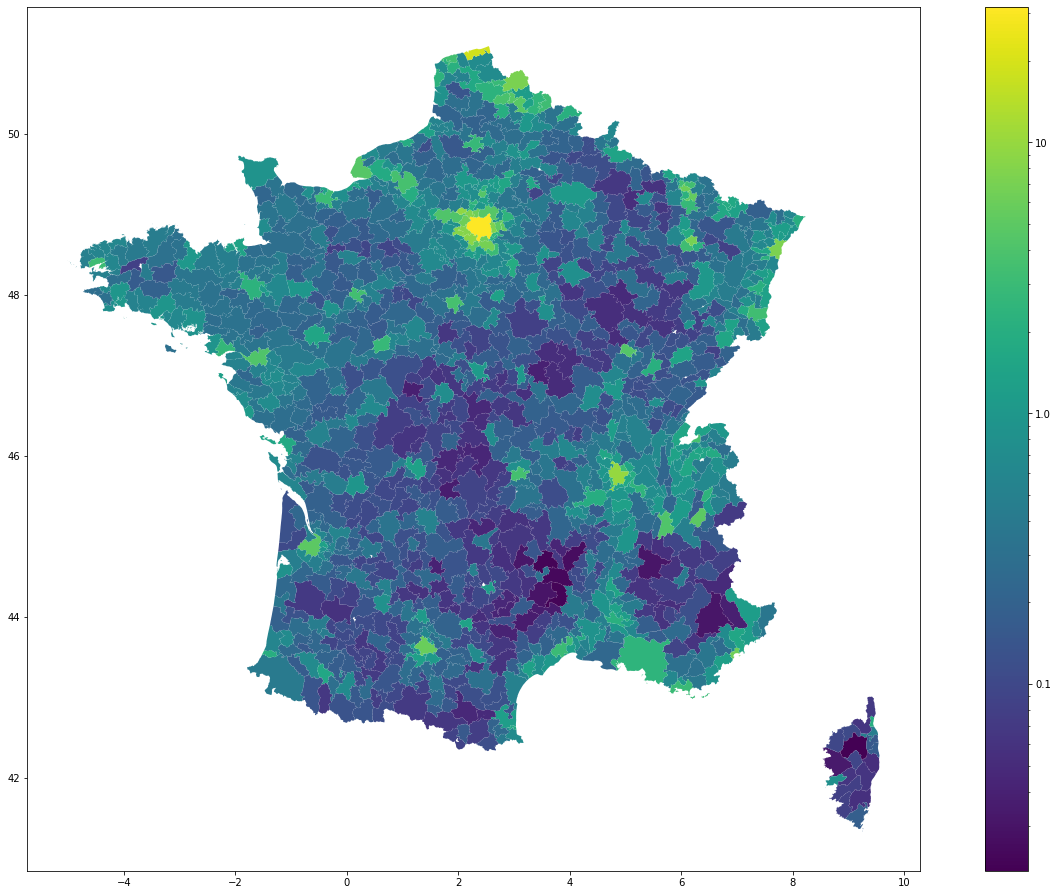

In [ ]:
#@title variable { run: "auto" }
var = "percent_surface_needed" #@param ["irradiance", "population", "surface_needed_percap", "surface_needed", "CONSO", "percent_surface_needed", "pv_energy_density", "conso_percap"]
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib as mpl
import numpy as np

min = EPCI_elec[var].min()
max = EPCI_elec[var].max()
norm = clrs.LogNorm(vmin=EPCI_elec[var].min(),
                    vmax=EPCI_elec[var].max())
cmap = mpl.cm.ScalarMappable(norm=norm)

fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 3])
#ax.axis(False)

plot = EPCI_elec.plot(ax=ax,
               column=var,
               norm=norm)
plt.colorbar(cmap, format=mpl.ticker.FuncFormatter(lambda x, pos: str(x) if x <= 1 else int(x)))
plt.show()
